# How to call day by day WOfS_albers data

Let's just copy and paste the standard set-up for working on the Geoscience Data Cube (from the Introduction_to_WOfS notebook on dea-notebooks). It's importing your usual modules for talking to the operating system, working with data, making plots and getting things from the datacube.

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser

#We have to add the plotting tools to the directory list with path.append
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

%load_ext autoreload

%autoreload 2

# OK, now that we're all set up, let's make a query!

Now set the query for searching through the data cube. Tantangara's location is at 35.75 S, 148.66 E. 6500 buffer is a good size to include the entire dam. Have a look at the period of interest. Don't make the timeframe too long or it will take a million years to load. Remember, you're working with a LOT of data now.

In [9]:
lat, lon, buffer = -35.75, 148.66, 6500
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2018-01-01', '2019-01-01'), #Try making this one year of data
         'crs': 'EPSG:3577'} #3577 is the EPSG number for Australia, you always set crs to that. 

wofs_albers is what the dataset is labelled as in the Geoscience Datacube. It is day by day data rather than a summary of all time. This is useful for linking to other datasets by date.

# OK time to dc.load! (this might take a while)

In [10]:
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', **query)
wofs_albers

<xarray.Dataset>
Dimensions:  (time: 70, x: 521, y: 521)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T23:57:01 ... 2018-12-28T23:50:34
  * y        (y) float64 -3.997e+06 -3.997e+06 ... -4.01e+06 -4.01e+06
  * x        (x) float64 1.495e+06 1.495e+06 1.495e+06 ... 1.508e+06 1.508e+06
Data variables:
    water    (time, y, x) int16 0 0 0 0 0 0 0 0 0 ... 80 80 80 80 80 80 80 80 80
Attributes:
    crs:      EPSG:3577

# ... and wofs.plot ;)

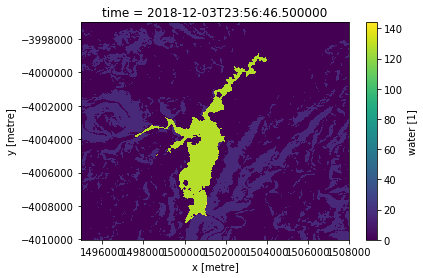

In [68]:
wofs_albers.water.isel(time=64).plot()
#water is the only attribute of wofs_albers
#hint, if you set the time to 2018-01-01, 2019-01-01 and then plot time=20 it's a good picture.
# another good one is set the time 2016-01-01 and 2017-01-01 and choose time=55 (this was in heavy rain i think)

If it's yellow, it's totally for sure water. If it's bluish purple, it ain't water. If you can't make out the dam, that day was cloudy. You can also call the data by date using the sel command to get the pass that was closest to that date:

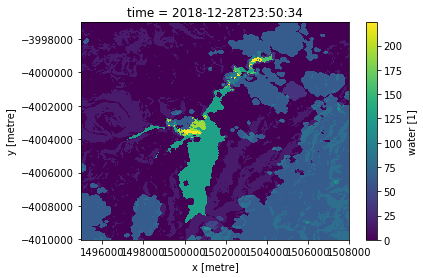

In [21]:
wofs_albers.water.sel(time='2019-02-01', method='nearest').plot()

There is a way to filter out the cloudy days so that you only get useful data when you link it to another dataset. I want good data to link to my stream gauge data. The only problem is that it snows in Tantangara, and I hope it doesn't discard clear winter days because it thinks the snow is cloud?!!??! We can figure that out later

# Let's make a cloud filter so we only get clear passes

Earlier we imported the 'masking' tool from datacube.storage. We're going to use that tool now to tell our algorithm not to retreive cloudy passes, only the clear passes. First we'll do it for just one day, and then we'll tell it to loop that command for all days. 

In [117]:
OneTime = wofs_albers.water.isel(time=1)

In [118]:
AllTheBitFlags = masking.make_mask(OneTime, cloud=False)

In [119]:
AllTheBitFlags.sum()

<xarray.DataArray 'water' ()>
array(210666)
Coordinates:
    time     datetime64[ns] 2018-01-02T23:52:49.500000

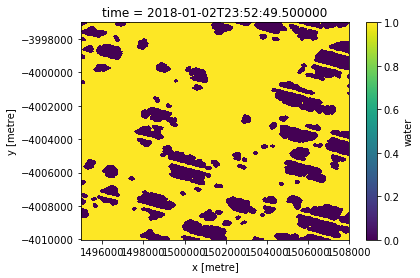

In [120]:
AllTheBitFlags.plot()

OK here, we're going to make a for-loop (Claire made this for me). ix means index. We want the algorithm to go through all the passes over Tantangara and show us only the clear passes with no cloud (you know, so we can actually see the dam)

In [109]:
ClearTimesteps = []
for ix, timestep in enumerate(wofs_albers.time):
    SingleTime = wofs_albers.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()
    
#Here's the part that measures the percentage of bit flags that mean cloud in the satellite image
    PercentCloudy = CountClouds.values.item()/(len(wofs_albers.x)*len(wofs_albers*y))*100
#And here's the part where we select how much cloud we're willing to accept in our satellite images. try 20. 
    IsItClearEnough = PercentCloudy <= 20
    
#Then we say 'if IsItClearEnough = True, then append it to an index called ClearTimesteps'.
    if IsItClearEnough:
        ClearTimesteps.append(ix)

OK, check this out. We've made a list of all the days that have less than a certain percentage cloud. Nice! 

In [110]:
ClearTimesteps

[4, 5, 9, 10, 11, 15, 20, 22, 23, 52, 58, 59, 60, 64]

So now we have a list of all the clear passes during that time period. Great job! Now we can use the index select command (isel) to call this list and do things with it. The isel command actually expects you to give it a dictionary but you can give it a list if you define a variable for it like so:

In [111]:
JustClearWOfS = wofs_albers.water.isel(time = ClearTimesteps)

In [112]:
JustClearWOfS.time

<xarray.DataArray 'time' (time: 14)>
array(['2018-01-17T23:56:54.000000000', '2018-01-18T23:52:36.000000000',
       '2018-02-03T23:52:20.000000000', '2018-02-10T23:58:25.500000000',
       '2018-02-11T23:50:31.000000000', '2018-03-07T23:51:59.000000000',
       '2018-04-07T23:56:15.500000000', '2018-04-16T23:49:59.000000000',
       '2018-04-23T23:56:06.000000000', '2018-09-22T23:54:36.500000000',
       '2018-10-25T23:50:35.000000000', '2018-11-10T23:50:37.500000000',
       '2018-11-17T23:56:48.000000000', '2018-12-03T23:56:46.500000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-17T23:56:54 ... 2018-12-03T23:56:46.500000
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [106]:
OneTime = JustClearWOfS.isel(time=10)

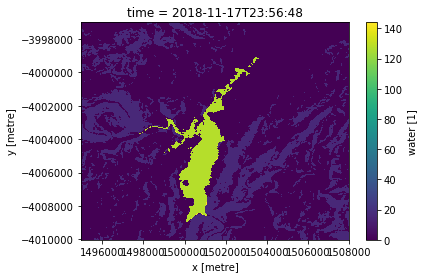

In [116]:
OneTime.plot()

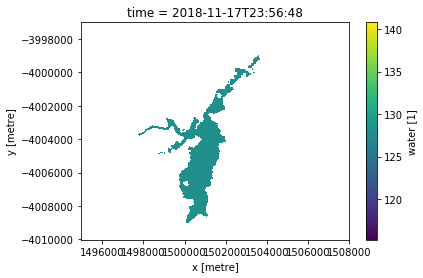

In [108]:
OneTime.where(OneTime==128).plot()